In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb   # General plotting library
import missingno as mn # Missing values visualization
import squarify        # Plotting countries

import Library         # Custom library wrapping the main statistical visualizations and processes 

## <hr><center>Load the two main datasets `matches_df` and create `all_players_df`.</center><hr>

In [ ]:
# Read the datasets from the .csv files in the root of this folder.
# Ideally, no notebook should read the raw .csv files present here, as they will be preprocessed by this notebook.
# At the end of this notebook, the resulting output dataset files will be saved in the "data_cleaned" folder, to make it accessible by other notebooks.
 
matches_df = pd.read_csv('tennis_matches.csv', index_col=0)
female_df  = pd.read_csv('female_players.csv')
male_df    = pd.read_csv('male_players.csv')

In [ ]:
# Concatenate the two males and females dataset together by adding the respective sex, so that they can be treated in a single dataframe.

male_df['sex'] = 'M'
female_df['sex'] = 'F'
all_players_df = male_df.append(female_df)

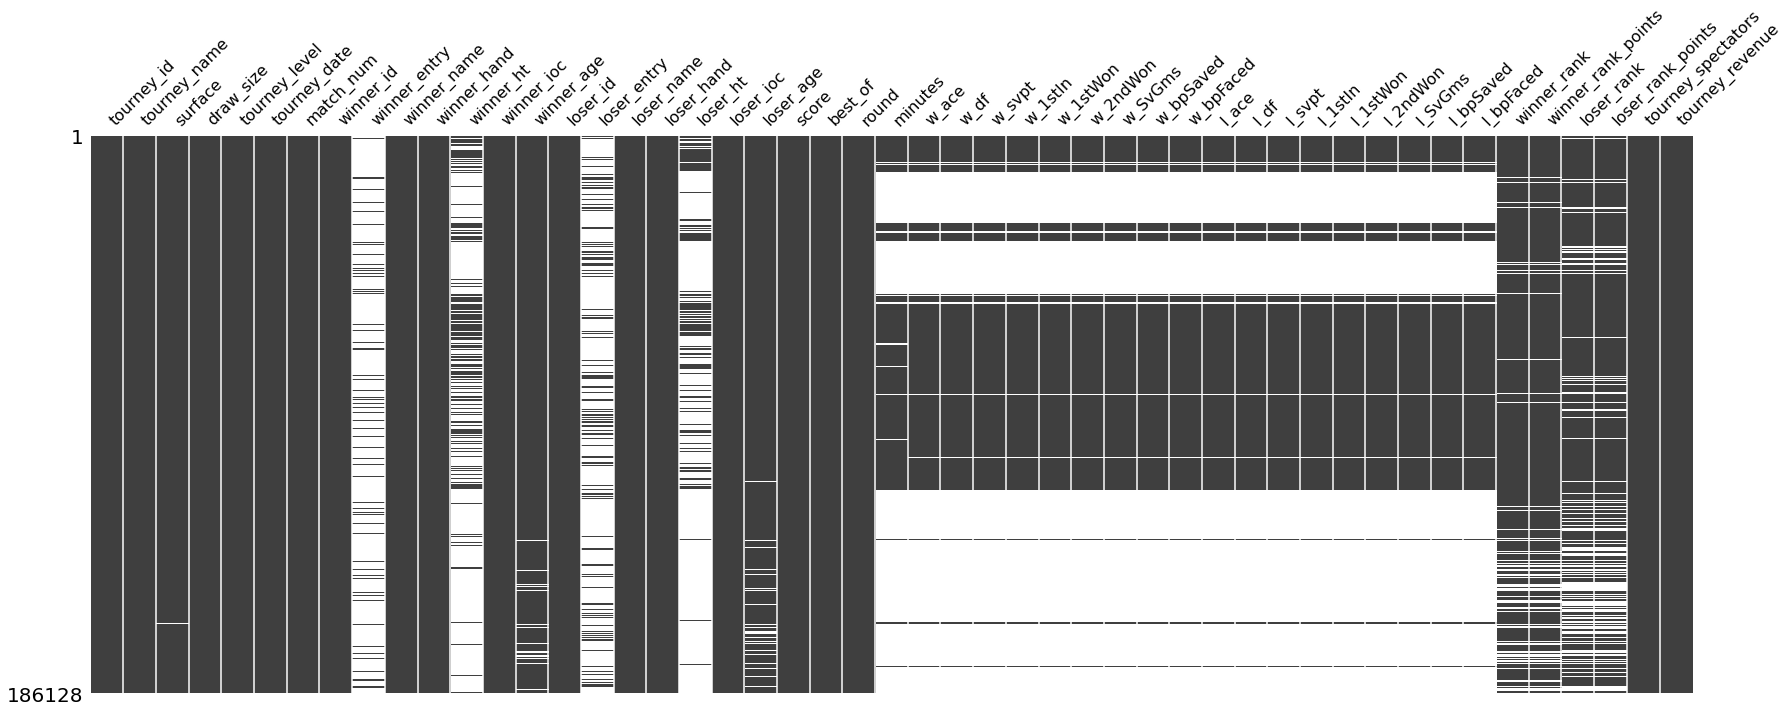

In [ ]:
# Use the missingno library to graphically visualize missing values for matches_df.
# This turned out to be particularly helpful at the beginning to understand the correlations in missing statistics insde 1matches_df.

mn.matrix(matches_df, sparkline=False); Library.save('missingno.png')

## <hr><center>Define the custom indicators on `matches_df` which include both sides.</center><hr>

In [ ]:
# Definition and intuition for defining ptWon%:
# Consider the number of first serve and second serve points won by a player.
# Then, we subtract the number of first and second serve points won by the opponent.
# Then, we divide the difference by the total number of points played in the game.
 
# We compute these common indicators at this point so that they can be preserved after the split of the match sides.

matches_df['w_ptWon%'] = ((matches_df['w_1stWon'] + matches_df['w_2ndWon']) - matches_df['l_1stWon'] - matches_df['l_2ndWon'] + matches_df['l_svpt']) / (matches_df['w_svpt'] + matches_df['l_svpt'])
matches_df['l_ptWon%'] = ((matches_df['l_1stWon'] + matches_df['l_2ndWon']) - matches_df['w_1stWon'] - matches_df['w_2ndWon'] + matches_df['w_svpt']) / (matches_df['l_svpt'] + matches_df['w_svpt'])

## <hr><center>Create `match_side_df` by splitting matches into winner and loser sides.</center><hr>

In [ ]:
# NEW FEATURE (matches_df): add a unique identifier for the match so that we can later retrieve the match structure using just match_side.

matches_df['match_id'] = matches_df.reset_index().index

# Create a new dataframe by joining together all winners and losers.
# The original dataframe can be obtained by performing a self join on the match_id.

# The two attribute names are simply combined in the final dataset. "w_" and "l_" are removed from the attribute names.
# We consider the case of both "winner_" and "w_" attributes.
# The following code simply applies a dropping of the loser from the winner and viceversa; then the attributes are renamed.

long_attributes = ['name', 'id', 'entry', 'hand', 'ht', 'ioc', 'age', 'rank', 'rank_points']
letter_attributes = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'ptWon%']

renaming_structure = lambda name, attributes: {f'{name}_{attr}':attr for attr in attributes}
dropping_structure = lambda name, attributes: [f'{name}_{attr}'      for attr in attributes]

winning_side_df = matches_df.rename(columns={**renaming_structure('winner', long_attributes), **renaming_structure('w', letter_attributes)})\
                              .drop(columns=dropping_structure('loser',     long_attributes) + dropping_structure('l',  letter_attributes))
losing_side_df  = matches_df.rename(columns={**renaming_structure('loser',  long_attributes), **renaming_structure('l', letter_attributes)})\
                              .drop(columns=dropping_structure('winner',    long_attributes) + dropping_structure('w',  letter_attributes))

# Finally, add a 'win' attribute so that the original structure can be reconstructed without loss of information.
# The value of the 'win' attribute is 1 if the winner is the player, and 0 otherwise.
winning_side_df['win'] = 1
losing_side_df['win']  = 0

# Concatenate the two winning and losing dataframes together.
match_side_df = pd.concat([winning_side_df,losing_side_df], axis=0)

# Sanity check that the number of matches is half of the number of match_side rows.
print('(matches_df)    Initial size =', matches_df.shape[0])
print('(match_side_df) Initial size =', match_side_df.shape[0])

(matches_df)    Initial size = 186128
(match_side_df) Initial size = 372256


In [ ]:
# Standardize the name attribute to full_name to mirror other datasets' semantics.
# This is done to avoid confusion with the name attribute of the players dataset.
match_side_df.rename(columns={'name': 'full_name'}, inplace=True)

## <hr><center>Data Understanding and Preparation on `all_players_df`.</center><hr>

In [ ]:
# Keep track of the total number of players present at the beginning in the dataset.
print('(all_players_df) Initial size =', all_players_df.shape[0])
 
# Delete players which have both NaN name and surname.
all_players_df = all_players_df[~(all_players_df['name'].isna() & all_players_df['surname'].isna())]
print('(all_players_df) Size after dropping nan name & surnames =', all_players_df.shape[0])

# Drop duplicate names.
all_players_df = all_players_df.drop_duplicates()
print('(all_players_df) Size after dropping duplicates =', all_players_df.shape[0])

# If the name is absent just use the surname and viceversa for the attribute.
def get_full_name(r):
    return r['name'] if pd.isna(r['surname']) else \
           r['surname'] if pd.isna(r['name']) else \
           f"{r['name']} {r['surname']}"

# Check that this transformation actually affects a non-zero number of records.
print('(all_players_df) Number of players with either name or surname NaN =', all_players_df[all_players_df['name'].isna() | all_players_df['surname'].isna()].shape[0])

# NEW FEATURE (all_players_df): add a full name given by the concatenation of name and surname.
# In case of a missing name, use the surname, and viceversa.
all_players_df['full_name'] = pd.concat([all_players_df['name'], all_players_df['surname']], axis=1).apply(get_full_name, axis=1)

(all_players_df) Initial size = 101380
(all_players_df) Size after dropping nan name & surnames = 101338
(all_players_df) Size after dropping duplicates = 100344
(all_players_df) Number of players with either name or surname NaN = 1696


## <hr><center>Data Understanding and Preparation on `match_side_df`.</center><hr>

In [ ]:
print('(match_side_df) Initial size =', match_side_df.shape[0])

# Keep only matches where both id and full name are present.
match_side_df = match_side_df[~match_side_df['id'].isna() & ~match_side_df['full_name'].isna()]

print('(match_side_df) Size after keeping only records with both name and id =', match_side_df.shape[0])

# Consider the number of unspecified hands so that they can be standardized to a common value.
print('(match_side_df) Unspecified hands =', (match_side_df['hand'] == 'U').sum())

# Replace unspecified U playing hand with NaN.
match_side_df.loc[match_side_df['hand'] == 'U', 'hand'] = np.nan

# Fix round BR to RR, this is probably the case of a typo.
print('(match_side_df) Number of corrected round names with "BR" =', match_side_df[match_side_df['round'] == 'BR'].shape[0])
match_side_df.loc[match_side_df['round'] == 'BR', 'round'] = 'RR'

# Clear the wrong date 'RR', this is a case where the tournament type was put inside the tourney date by mistake.
print('(match_side_df) Number of corrected dates with "RR" =', match_side_df[match_side_df['tourney_date'] == 'RR'].shape[0])
match_side_df.loc[match_side_df['tourney_date'] == 'RR', 'tourney_date'] = np.nan

# Finally, drop duplicates on the dataset.
print('(match_side_df) Before dropping duplicates =', match_side_df.shape[0])
match_side_df.drop_duplicates(inplace=True)
print('(match_side_df) After dropping duplicates =', match_side_df.shape[0])

(match_side_df) Initial size = 372256
(match_side_df) Size after keeping only records with both name and id = 372159
(match_side_df) Unspecified hands = 111161
(match_side_df) Number of corrected round names with "BR" = 10
(match_side_df) Number of corrected dates with "RR" = 0
(match_side_df) Before dropping duplicates = 372159
(match_side_df) After dropping duplicates = 372159


## <hr><center>Create a dataset with all the people which appear in at least a match, `players_df`.</center><hr>

In [ ]:
# The 'players_df' is a dataframe with all the information of players which actually played at least one game, i.e.: they have a player_id.
# We obtain all the names that appear in all matches along with their respective ids.
# We then drop the duplicates because each person can play multiple times in the matches.

players_df = match_side_df[['id', 'full_name']].drop_duplicates()

print('(players_df) Number of players that played at least 1 game =', players_df.shape[0])

# Drop NaN values on the full name attribute, in case of under-specification.
players_df = players_df[~players_df['full_name'].isna()]

# Print both dataset size in order to compare them. Clearly, most of the players have never played a game.
# We suspect that these two datasets might be originated from different sources.
# Indeed, the most important use of players_df is to assign a gender and to check for typos.
print('(players_df) Players after dropping NaN =', players_df.shape[0])
print('(players_df) All players =', all_players_df.shape[0])

(players_df) Number of players that played at least 1 game = 10123
(players_df) Players after dropping NaN = 10123
(players_df) All players = 100344


In [ ]:
# Check that each name in the players_df appears once and exactly once in the all_players_df.

print("Set difference between players and all_players: ", len(set(players_df['full_name']).difference(set(all_players_df['full_name']))))

# It turns out that 30 names in the match_side_df (and thus players_df) are not in the all_players_df.

# So, given the small number of players that have played at least one match, we decided to fix them.
# We can identify two cases:
#    1) The name contains a typo and it actually exists in all_players_df.
#       This is the case for 29 records.
#    2) The name does not appear in all_players_df in general.
#       This is the case for just 1 record, Evgenii Tiurnev. We manually added him since he has 70 matches.

# Fix the typos in the names of players_df and match_side_df.
correct_names = {
    'Alexandar Lazov': 'Alexander Lazov',
    'Alona Fomina': 'Alena Fomina',
    'Andres Artunedo Martinavarro': 'Andres Artunedo Martinavarr',
    'Antoine Hoang': 'Antonie Hoang',
    'Ben Patael': 'Ben Fatael',
    'Botic van de Zandschulp': 'Botic Van De Zandschulp',
    "Christopher O'Connell": "Christopher Oconnell",
    'Cristian Garin': 'Christian Garin',
    'Daniel Elahi Galan': 'Daniel Elahi Galan Riveros',
    'Daniel Munoz de la Nava': 'Daniel Munoz De La Nava',
    "David O'Hare": "David Ohare",
    'Diego Schwartzman': 'Diego Sebastian Schwartzman',
    'Frances Tiafoe': 'Francis Tiafoe',
    'Franko Skugor': 'Franco Skugor',
    'Holger Rune': 'Holger Vitus Nodskov Rune',
    'J.J. Wolf': 'Jeffrey John Wolf',
    'Jo-Wilfried Tsonga': 'Jo Wilfried Tsonga',
    'Joao Menezes': 'Joao Lucas Magalhaes Hueb De Menezes',
    'Juan Martin del Potro': 'Juan Martin Del Potro',
    'Juan Pablo Varillas': 'Juan Pablo Varillas Patino Samudio',
    'Jurabek Karimov': 'Djurabek Karimov',
    'Khumoun Sultanov': 'Khumoyun Sultanov',
    'Lloyd Harris': 'Lloyd George Muirhead Harris',
    'Mackenzie McDonald': 'Mackenzie Mcdonald',
    'Pedro Martinez': 'Pedro Martinez Portero',
    'Sam Groth': 'Samuel Groth',
    'Stan Wawrinka': 'Stanislas Wawrinka',
    'Taylor Fritz': 'Taylor Harry Fritz',
    'Zeynep  Sena Sarioglan': 'Zeynep Sena Sarioglan'
}
for wrong_name, correct_name in correct_names.items():
    players_df.loc[players_df['full_name']       == wrong_name, 'full_name'] = correct_name
    match_side_df.loc[match_side_df['full_name'] == wrong_name, 'full_name'] = correct_name

print('(players_df) Initial size =', players_df.shape[0])

# It turns out that for 2 records (namely, "Alona Fomina" and "Zeynep  Sena Sarioglan") the correct name
# already appears inside of players_df. For this reason, we collapse them by dropping duplicates.
players_df = players_df.drop_duplicates()

print('(players_df) Playing players after removing duplicates =', players_df.shape[0])

# Add the missing player "Evgenii Tiurnev" from all_players_df.
all_players_df = all_players_df.append({'name':'Evgenii', 'surname':'Tiurnev', 'sex':'M', 'full_name':'Evgenii Tiurnev'}, ignore_index=True)

(players_df) Initial size = 10123
(players_df) Playing players after removing duplicates = 10121


In [ ]:
# We checked for people which appear in both the female and male datasets:
# We verify the constraints by running these two lines, decommented here for speeding up notebook execution:

#all_players_name_counts = all_players_df['full_name'].value_counts()
#multisex_names = all_players_name_counts[all_players_name_counts > 1].index.to_list()

# Among all of these records which appear as both male and female, we consider only those that have played a match.
# We determined their correct gender by looking at the gender of their opponents inside matches, and we proceed by fixing their gender manually.
# Furthermore, all of these names appear with the same id inside players_df.

#for name in multisex_names:
#    num_match = match_side_df[(match_side_df['name'] == name)].shape[0]
#    if num_match > 0:
#        opponents = match_side_df[match_side_df['name']==name]['name']
#        print(name, '\t\t', num_match, set(all_players_df[all_players_df['full_name'].isin(opponents)]['sex']))

# Drop the player entry with the wrong sex inside all_players_df
# We do not drop "Kuan Yi Lee" since it played with both males and females,
# which proves that there are actually two different people with different sex.
# We used Google Search to confirm this fact and it turns out that there are two different people.

all_players_df.drop(all_players_df[(all_players_df['full_name']=='Ziyu Zhang')   & (all_players_df['sex']=='M')].index, inplace = True)
all_players_df.drop(all_players_df[(all_players_df['full_name']=='Yi Liu')       & (all_players_df['sex']=='M')].index, inplace = True)
all_players_df.drop(all_players_df[(all_players_df['full_name']=='Austin Smith') & (all_players_df['sex']=='F')].index, inplace = True)
all_players_df.drop(all_players_df[(all_players_df['full_name']=='Yang Liu')     & (all_players_df['sex']=='F')].index, inplace = True)
all_players_df.drop(all_players_df[(all_players_df['full_name']=='Di Zhao')      & (all_players_df['sex']=='M')].index, inplace = True)

In [ ]:
# We consider all the players which had a duplicate full_name inside players_df with different id.
# There are 38 such records.

duplicate_full_names = players_df[players_df.duplicated('full_name', keep=False)].sort_values('full_name')

print('(duplicate_full_names) Number of duplicated full names =', duplicate_full_names.shape[0])

# We then checked if these records had same name but different gender; it turns out that
# there is such a case, Kuan Yi Lee, which legitimately appears as two different people with different sex.
# For "Kuan Yi Lee", id 221745 is female & id 134120 is male.

(duplicate_full_names) Number of duplicated full names = 38


In [ ]:
# We assumed in the remaining cases to have identical player but registered under different player_id.
# For this reason, we chose to remove one of the two records and appropriately change the player_id in match_side_df.

print('(duplicate_full_names) Number of duplicated full names =', duplicate_full_names.shape[0])

# Pick the first ID as the correct one.
duplicate_full_names.drop_duplicates(subset=['full_name'], keep='first', inplace=True)

# Exclude 'Kuan Yi Lee' from the lines to remove, since it's legitimately two different people.
different_gender_exception = 'Kuan Yi Lee'
duplicate_full_names = duplicate_full_names[duplicate_full_names['full_name'] != different_gender_exception]

print('(duplicate_full_names) Number of corrected names =', duplicate_full_names.shape[0])

# Replace in all matches the duplicated people ID with their correct one.
for _, dupl in duplicate_full_names.iterrows():
    match_side_df.loc[match_side_df['full_name'] == dupl['full_name'], 'id'] = dupl['id']

# Drop the incorrect players which have identical name but the id is not the correct one in duplicate_full_names.
for _, dupl in duplicate_full_names.iterrows():
    players_df = players_df[~((players_df['full_name'] == dupl['full_name']) & (players_df['id'] != dupl['id']))]
    
print('(players_df) Initial size =', players_df.shape[0])

# This should give us -18 records, as duplicate_full_names has 18 records.
print('(players_df) Size after removing duplicate full_names =', players_df.shape[0])

# This is correct as it can also be witnessed by the following query:
#print(players_df[players_df.duplicated('full_name', keep=False)])

(duplicate_full_names) Number of duplicated full names = 38
(duplicate_full_names) Number of corrected names = 18
(players_df) Initial size = 10103
(players_df) Size after removing duplicate full_names = 10103


In [ ]:
# Now that we dealt with the above cases, we can actually merge players_df and
# all_players_df in order to obtain the gender. Thanks to the previous corrections,
# we do not lose any record due to missing name in the all_players_df table.
players_df = players_df.merge(all_players_df, on='full_name')

# Drop the two incorrect records for 'Kuan Yi Lee' which appear after the join (see above).
players_df.drop(players_df[(players_df['id'] == 221745) & (players_df['sex'] == 'M')].index, inplace=True)
players_df.drop(players_df[(players_df['id'] == 134120) & (players_df['sex'] == 'F')].index, inplace=True)

print('(players_df) Number of players who at least played once =', players_df.shape[0])

(players_df) Number of players who at least played once = 10103


## <hr><center>Assign unique `id`s for `players_df` in both datasets.</center><hr>

In [ ]:
# NEW FEATURE (players_df): add a unique identifier for the player so that we can later retrieve the player matches using just player_id

# Rename the old id column to old_id
players_df = players_df.rename(columns={'id': 'old_id'})
match_side_df = match_side_df.rename(columns={'id': 'old_id', 'name': 'full_name'})

# Add the new incremental unique index to the players
players_df['id'] = players_df.reset_index().index

print('(players_df) Initial size =', players_df.shape[0])

# Inside match_side_df, we replace the pair of old player_id and full_id by using player_id we just created
match_side_df = match_side_df.merge(players_df[['full_name', 'old_id', 'id']], on=['full_name', 'old_id'])
# Drop the old columns
match_side_df.drop(columns=['full_name', 'old_id'], inplace=True)
players_df.drop(columns=['old_id'], inplace=True)

(players_df) Initial size = 10103


<hr><hr>

From this point onward, we can perform proper statistical analyses on matches and players, since matches and players are connected together without errors.

<hr><hr>

## <hr><center>Create the composite indicators for `match_side_df`.</center><hr>

In [ ]:
# NEW FEATURES (matches_side_df): we now compute the most important synthetized match_side_df statistics.

# The definition of the following indicators has been checked by comparing the resulting indicators with publicly available data on famous players.

# First serve percentage
match_side_df['1st%'] = match_side_df['1stIn'].divide(match_side_df['svpt'].where(match_side_df['svpt'] != 0))
# First serve win percentage
match_side_df['1stWin%'] = match_side_df['1stWon'].divide(match_side_df['1stIn'].where(match_side_df['1stIn'] != 0))
# Second serve inside count
match_side_df['2ndIn'] = match_side_df['svpt'] - match_side_df['1stIn'] - match_side_df['df']
# Second serve percentage
match_side_df['2nd%'] = match_side_df['2ndIn'].divide(match_side_df['svpt'].where(match_side_df['svpt'] != 0))
# Second serve win percentage
match_side_df['2ndWin%'] = match_side_df['2ndWon'].divide(match_side_df['2ndIn'].where(match_side_df['2ndIn'] != 0))

# Ace percentage
match_side_df['ace%'] = match_side_df['ace'].divide(match_side_df['svpt'].where(match_side_df['svpt'] != 0))
# Double faults percentage
match_side_df['df%'] = match_side_df['df'].divide(match_side_df['svpt'].where(match_side_df['svpt'] != 0))

# Serve points won percentage
match_side_df['svptWon%'] = (match_side_df['1stWon'] + match_side_df['2ndWon']).divide(match_side_df['svpt'].where(match_side_df['svpt'] != 0))

# Break points saved percentage
match_side_df['bpSaved%'] = match_side_df['bpSaved'].divide(match_side_df['bpFaced'].where(match_side_df['bpFaced'] != 0))

# Add binary indicator variables to simplify computations over surface types and winrates.
match_side_df['is_grass']       = match_side_df['surface'] == 'Grass'
match_side_df['is_grass_win']   = match_side_df['is_grass'] & match_side_df['win']
match_side_df['is_hard']        = match_side_df['surface'] == 'Hard'
match_side_df['is_hard_win']    = match_side_df['is_hard'] & match_side_df['win']
match_side_df['is_clay']        = match_side_df['surface'] == 'Clay'
match_side_df['is_clay_win']    = match_side_df['is_clay'] & match_side_df['win']
match_side_df['is_carpet']      = match_side_df['surface'] == 'Carpet'
match_side_df['is_carpet_win']  = match_side_df['is_carpet'] & match_side_df['win']

# Round types of the match inside the tournament
match_side_df['is_R32']     = match_side_df['round'] == 'R32'
match_side_df['is_R16']     = match_side_df['round'] == 'R16'
match_side_df['is_R8']      = match_side_df['round'] == 'QF'
match_side_df['is_R4']      = match_side_df['round'] == 'SF'
match_side_df['is_R2']      = match_side_df['round'] == 'F'

# Is this match a tournament win?
match_side_df['is_tournament_win'] = match_side_df['is_R2'] & match_side_df['win']

In [ ]:
# Add a flag 'is_statistical' to the match to see if all statistical attributes are non-null. (i.e.: the match is of statistical importance)
# As we verified at the beginning of the notebook, the majority of the matches are so that either all statistical attributes are null or they are not.
# Note that we do not check here for rank or rank_points.

match_side_df['is_statistical'] = \
    ~match_side_df['ace'].isna() & \
    ~match_side_df['df'].isna() & \
    ~match_side_df['svpt'].isna() & \
    ~match_side_df['1stIn'].isna() & \
    ~match_side_df['1stWon'].isna() & \
    ~match_side_df['2ndWon'].isna() & \
    ~match_side_df['SvGms'].isna() & \
    ~match_side_df['bpSaved'].isna() & \
    ~match_side_df['bpFaced'].isna() & \
    ~match_side_df['ptWon%'].isna() & \
    ~match_side_df['1st%'].isna() & \
    ~match_side_df['1stWin%'].isna() & \
    ~match_side_df['2ndIn'].isna() & \
    ~match_side_df['2nd%'].isna() & \
    ~match_side_df['2ndWin%'].isna() & \
    ~match_side_df['ace%'].isna() & \
    ~match_side_df['df%'].isna() & \
    ~match_side_df['svptWon%'].isna() & \
    ~match_side_df['bpSaved%'].isna()

In [ ]:
# Decompose the tourney_date into year, month, day.
# We report the distribution of the years of the tournament in the report, but we do not elaborate further on this attribute.

match_side_df.loc[match_side_df['tourney_date'].isna(), 'tourney_date'] = 20211110.0

match_side_df['year']  = np.floor(match_side_df['tourney_date'] / 10000).astype(int)
match_side_df['month'] = np.floor(match_side_df['tourney_date'] / 100).mod(100)
match_side_df['day']   = np.floor(match_side_df['tourney_date']).mod(100)

## <hr><center>Main statistics computation on `match_side_df`.</center><hr>

In [ ]:
# Most important statistics for match_side_df for which we check outliers, correlation.

# Define threshold combinators for outliers, these are used in match_side_statistics to exclude outliers.
lt = lambda v: lambda x: x < v            # Restricts the value to be under the threshold.
gt = lambda v: lambda x: x > v            # Restricts the value to be above the threshold.
perc = lambda x: (0 <= x) & (x <= 1)      # Restricts the value to be between 0 and 1.
and_ = lambda p, q: lambda x: p(x) & q(x) # Combine two outliers thresholds in conjunction.

# Default histogram number of bins.
bins = 50

# This dictionary contains all relevant information and processing that we apply on the dataset.
# This gives an easily modifiable, declarative, and modular way to control the entire analysis, with all important information in one place.

# Most indications are self-explanatory: the info collects tags on the kind of attribute, while 'outliers' and 'cutting'
# refer to the outliers exclusion function and the red dotted line to display on histograms, respectively.
# The 'num' and 'obj' tags refer to the kind of attribute (numerical or categorical) that we are processing.
# 'value-counts' is used to visualize histograms on categorical attributes instead of standard bin-based histograms.
# Finally, the 'hidden' is used to exclude attributes we do not want to see inside of histograms and boxplots.

# For more details, consult the functions inside Library.py.

match_side_statistics = {         
  # Match statistics                           
  '1stIn':               {'info': ['num']                , 'bins': bins, 'cutting': [100],    'outliers': lt(100)},                                               
  '1stWon':              {'info': ['num']                , 'bins': bins, 'cutting': [100],    'outliers': lt(100)},        
  '1st%':                {'info': ['num','percentage']   , 'bins': bins, 'cutting': [0.1],    'outliers': and_(perc,gt(0.1))},                                
  '1stWin%':             {'info': ['num','percentage']   , 'bins': bins, 'cutting': [0.07],   'outliers': perc},                                      
  '2ndIn':               {'info': ['num']                , 'bins': bins, 'cutting': [100],    'outliers': lt(100)},                                                
  '2ndWon':              {'info': ['num']                , 'bins': 80,   'cutting': [100],    'outliers': lt(100)},                                        
  '2nd%':                {'info': ['num','percentage']   , 'bins': bins, 'cutting': [0.9],    'outliers': and_(perc,lt(0.9))},                                
  '2ndWin%':             {'info': ['num','percentage']   , 'bins': bins, 'cutting': [1.0],    'outliers': perc},                                 
  'ace':                 {'info': ['num']                , 'bins': bins, 'cutting': [50],     'outliers': lt(50)},                                     
  'ace%':                {'info': ['num','percentage']   , 'bins': bins, 'cutting': [0.8],    'outliers': and_(perc,lt(0.8))},                                             
  'bpFaced':             {'info': ['num']                , 'bins': bins, 'cutting': [50],     'outliers': lt(50)},                                         
  'bpSaved':             {'info': ['num']                , 'bins': bins, 'cutting': [50],     'outliers': lt(50)},                                         
  'bpSaved%':            {'info': ['num','percentage']   , 'bins': bins, 'cutting': [],       'outliers': perc},                                          
  'df':                  {'info': ['num']                , 'bins': bins, 'cutting': [25],     'outliers': lt(25)},                                    
  'df%':                 {'info': ['num','percentage']   , 'bins': bins, 'cutting': [0.4],    'outliers': and_(perc,lt(0.4))},                                          
  'ptWon%':              {'info': ['num','percentage']   , 'bins': bins, 'cutting': [],       'outliers': perc},                             
  'SvGms':               {'info': ['num']                , 'bins': bins, 'cutting': [45],     'outliers': lt(45)},
  'svpt':                {'info': ['num']                , 'bins': 69,   'cutting': [300, 1], 'outliers': and_(gt(0),lt(300))},
  'svptWon%':            {'info': ['num','percentage']   , 'bins': bins, 'cutting': [],       'outliers': perc},                                       
  # General match properties and player statistics 
  'age':                 {'info': ['num'], 'bins': bins, 'cutting': [50],     'outliers': lt(50)},                                       
  'ht':                  {'info': ['num'], 'bins': bins, 'cutting': [100],    'outliers': gt(100)},                                   
  'minutes':             {'info': ['num'], 'bins': bins, 'cutting': [450],    'outliers': lt(450)},  
  'rank':                {'info': ['num']},                                       
  'rank_points':         {'info': ['num']},                      
  'surface':             {'info': ['obj','value-counts']},       
  'hand':                {'info': ['obj']},
  'year':                {'info': ['date-int','value-counts']},
  'month':               {'info': ['hidden','date-int']},
  'day':                 {'info': ['hidden','date-int']},                        
  'ioc':                 {'info': ['hidden','obj']},                                       
  'id':                  {'info': ['hidden','int']},                                              
  'match_id':            {'info': ['hidden','int']},                                            
  'match_num':           {'info': ['hidden','num']}, 
  # Tourney attributes                                                                         
  'tourney_date':        {'info': ['hidden','num']},    
  'draw_size':           {'info': ['hidden','num']}, 
  'round':               {'info': ['hidden','obj']},                                      
  'best_of':             {'info': ['hidden','int']},       
  'score':               {'info': ['hidden','obj']},       
  'entry':               {'info': ['hidden','obj']},               
  'tourney_id':          {'info': ['hidden','obj']},                                             
  'tourney_level':       {'info': ['hidden','obj']},                                                
  'tourney_name':        {'info': ['hidden','obj']},                                               
  'tourney_revenue':     {'info': ['hidden','num']},                                                  
  'tourney_spectators':  {'info': ['hidden','num']},            
  # Boolean indicators on the kind of match                       
  'is_R32':              {'info': ['hidden','bool']},                                         
  'is_R16':              {'info': ['hidden','bool']},                                        
  'is_R8':               {'info': ['hidden','bool']},                                        
  'is_R4':               {'info': ['hidden','bool']},                                         
  'is_R2':               {'info': ['hidden','bool']},   
  'is_clay':             {'info': ['hidden','bool']},                                          
  'is_clay_win':         {'info': ['hidden','bool']},                                              
  'is_grass':            {'info': ['hidden','bool']},                                           
  'is_grass_win':        {'info': ['hidden','bool']},                                               
  'is_hard':             {'info': ['hidden','bool']},                                          
  'is_hard_win':         {'info': ['hidden','bool']},                                               
  'is_carpet':           {'info': ['hidden','bool']},                                          
  'is_carpet_win':       {'info': ['hidden','bool']},                                          
  'is_tournament_win':   {'info': ['hidden','bool']},                                                  
  'win':                 {'info': ['hidden','bool']},                                                    
  'is_statistical':      {'info': ['hidden','bool']},                  
  }


## <hr><center>Eliminate outliers in the most important attributes of `match_side_df`.</center><hr>

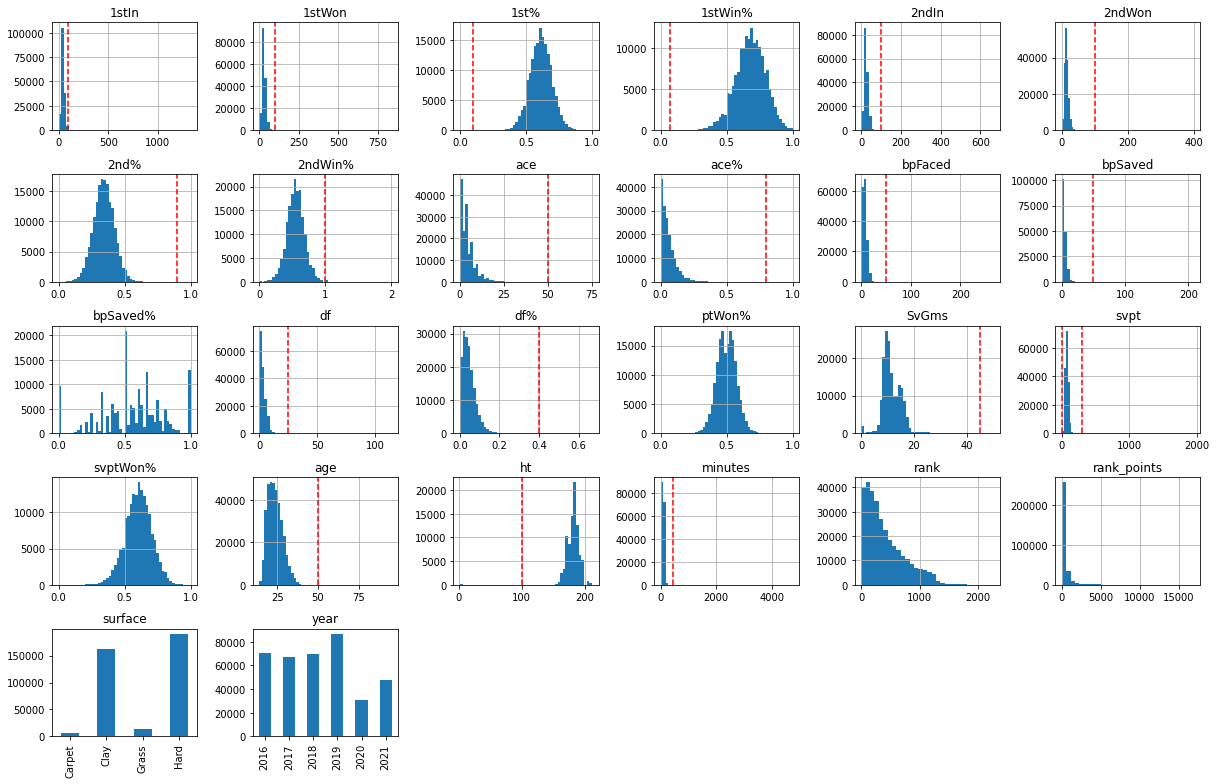

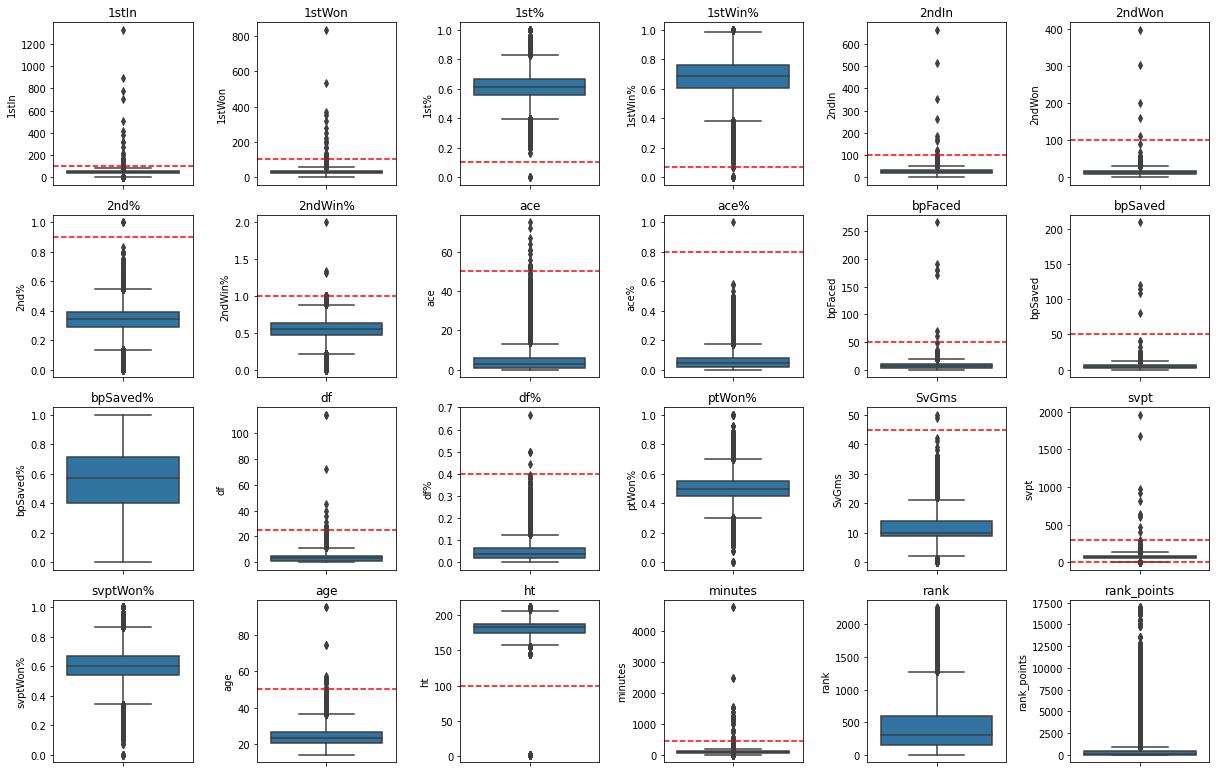

In [ ]:
# Temporary global flag to speedup the code during code iterations.
plot_histograms_and_boxplots          = True
show_outliers_histograms_and_boxplots = True

# Generic function to display histograms and boxplots.
# :param stats: List of strings, statistics for which to display histograms and boxplots.
# :param hr, hc, br, bc: Matrix size for the (h)ristogram and (b)oxplots boxplots, as (r)ows and (c)olumns.
# :param f1_name: Filename for histograms.
# :param f2_name: Filename for boxplots.
# :param size: size for the graphs.
def histograms_and_boxplots(stats, hr, hc, br, bc, df, f1_name, f2_name, size):
    def histograms(a): 
        # Display histograms of the features. Use value_counts for categorical attributes for which it is specified.
        if 'value-counts' in stats[a]['info']:
            df[a].value_counts().sort_index().plot(kind='bar')
        else:
            # Obtain the number of bins, else default.
            df[a].hist(bins=stats[a]['bins'] if 'bins' in stats[a] else bins) 
            # Add a cutting line for the histograms if 'cutting' is defined.
            if show_outliers_histograms_and_boxplots and 'cutting' in stats[a]:
                for c in stats[a]['cutting']:
                    plt.axvline(x=c, color="red", linestyle='--')
        
    def boxplots(a):
        # Display boxplots only if value-counts is not specified.
        if 'value-counts' not in stats[a]['info']:
            plt.suptitle('')
            sb.boxplot(y=a, data=df)
            # Add a cutting line for the boxplots if 'cutting' is defined.
            if show_outliers_histograms_and_boxplots and 'cutting' in stats[a]:
                for c in stats[a]['cutting']:
                    plt.axhline(y=c, color="red", linestyle='--')
                
    # Obtain all the numerical attributes.
    num_attributs = Library.numerical_attributes(stats)
    # Add those with value-counts to represent them as categorical attributes.
    attributes = num_attributs + Library.attributes_with(stats, 'value-counts')
    # Finally, check that hide-histograms is not enabled.
    attributes = [a for a in attributes if 'hide-histogram' not in stats[a]['info']]
    if plot_histograms_and_boxplots:
        # Plot histograms, adjusting for size.
        plt.gcf().set_size_inches(*size)
        Library.plot_matrix(hr, hc, attributes, histograms)
        Library.save(f1_name)
        plt.show()
        # Plot boxplots, adjusting for size..
        plt.gcf().set_size_inches(*size)
        Library.plot_matrix(br, bc, num_attributs, boxplots)
        Library.save(f2_name)
        plt.show()

# Default definition for match_size
match_side_df_histograms_and_boxplots = lambda f1_name, f2_name: histograms_and_boxplots(match_side_statistics, 5, 6, 4, 6, match_side_df, f1_name, f2_name, size=(17, 11))

# Immediately call this function so as to plot the statistics for match_side.
# This is then called again AFTER we remove the outliers, in order to verify how the data distribution and plots have been affected.
# This allowed us to check very quickly if a more refined cut was needed, giving us quick feedback.
match_side_df_histograms_and_boxplots("match_side_df_hists.svg", "match_side_df_boxplots.png")

# Temporary global flag to speedup the code.
show_outliers_histograms_and_boxplots = False

In [ ]:
# Execute the outlier removal process using the statistics of match_side_df described above.

print(f"(match_side_df) Initial size: {match_side_df.shape[0]}")

# Give a callback function to see the progress of the outlier removal for each attribute.
match_side_df = Library.drop_outliers(match_side_df, match_side_statistics,\
                                      lambda df, a: print(f"(match_side_df) Size after cleaning {repr(a):<10}:\t\t{df.shape[0]}"))

print(f"(match_side_df) After removing outliers: {match_side_df.shape[0]}")


(match_side_df) Initial size: 372159
(match_side_df) Size after cleaning '1stIn'   :		371332
(match_side_df) Size after cleaning '1stWon'  :		371332
(match_side_df) Size after cleaning '1st%'    :		371326
(match_side_df) Size after cleaning '1stWin%' :		371326
(match_side_df) Size after cleaning '2ndIn'   :		371326
(match_side_df) Size after cleaning '2ndWon'  :		371326
(match_side_df) Size after cleaning '2nd%'    :		371326
(match_side_df) Size after cleaning '2ndWin%' :		371323
(match_side_df) Size after cleaning 'ace'     :		371322
(match_side_df) Size after cleaning 'ace%'    :		371321
(match_side_df) Size after cleaning 'bpFaced' :		371321
(match_side_df) Size after cleaning 'bpSaved' :		371321
(match_side_df) Size after cleaning 'bpSaved%':		371321
(match_side_df) Size after cleaning 'df'      :		371316
(match_side_df) Size after cleaning 'df%'     :		371313
(match_side_df) Size after cleaning 'ptWon%'  :		371313
(match_side_df) Size after cleaning 'SvGms'   :		371313
(match_side

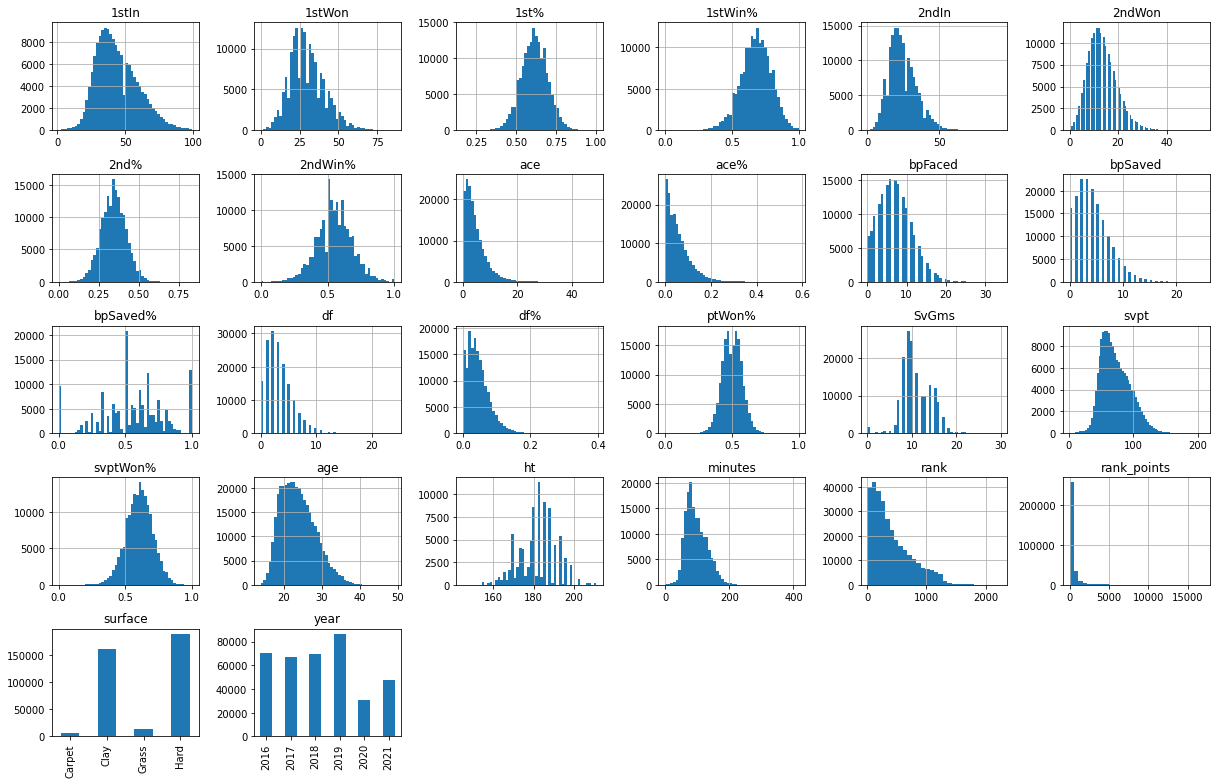

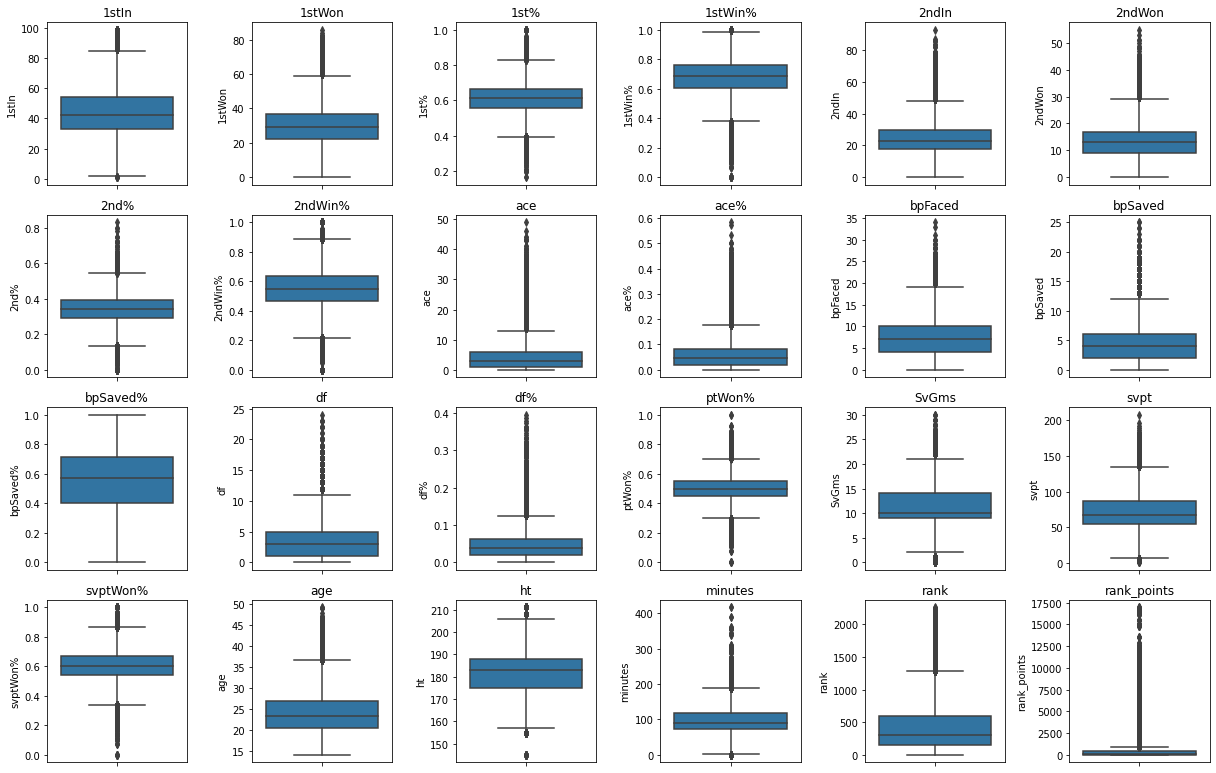

In [ ]:
# Repeat the histograms and boxplots displaying process now that outliers have been removed.
# This allows for a quick iteration process to check the quality of the resulting plots.
match_side_df_histograms_and_boxplots("match_side_df_hists_no_outliers.svg", "match_side_df_boxplots_no_outliers.png")

In [ ]:
# As sanity check, 
# Check the most relevant semantic constraints on the attributes of match_side_df actually hold on the dataset.

is_empty = lambda df: df.shape[0] == 0
# Aces are alwas greater than first serves executed with success.
assert is_empty(match_side_df[match_side_df['ace']     > match_side_df['1stIn']])
# The number of serve points is always greater than the number of possible serve outcomes.
assert is_empty(match_side_df[match_side_df['svpt']    > match_side_df['1stIn'] + match_side_df['2ndIn'] + match_side_df['df']])
# The number of break points saved is always greater than the number of break points faced in total.
assert is_empty(match_side_df[match_side_df['bpSaved'] > match_side_df['bpFaced']])
# The number of first serves won is always greater than the number of first serves that got the ball in.
assert is_empty(match_side_df[match_side_df['1stWon']  > match_side_df['1stIn']])
# Similarly, for the second serve.
assert is_empty(match_side_df[match_side_df['2ndWon']  > match_side_df['2ndIn']])

# Check that country is consistent across matches (4 inconsistent rows, player ids: 1023, 1272, 8991, 9209)
# Given the low number of discrepancies, we simply consider the first country as the correct one.
print((match_side_df[['id', 'ioc']].groupby('id').nunique() > 1).sum())

# Check that hand is consistent across matches (no inconsistencies)
print((match_side_df[['id', 'hand']].groupby('id').nunique() > 1).sum())

ioc    4
dtype: int64
hand    0
dtype: int64


In [ ]:
# Old code used for experimenting with outlier removal based on IQR. 
# Unfortunately, as we mentioned in the project report, IQR did not work well
# on this dataset as it frequently removed the best players, which naturally have very good statistics.

#def drop_iqr(s,a, iqr_t):
#    Q1, Q3 = s[a].quantile(0.25), s[a].quantile(0.75)
#    IQR = Q3 - Q1
#    return s[(Q1 - iqr_t*IQR <= s[a]) & (s[a] <= Q3 + iqr_t*IQR)]
#iqr_attributes_match_side_df = ['age','minutes','ace','df','svpt','1stIn','1stWon','2ndWon','SvGms','bpSaved','bpFaced',\
#                                '1st%','1stWin%','2ndIn','2nd%','2ndWin%','bpSaved%','svptWon%']
#print('(match_side_df) Initial size =', match_side_df.shape[0])
#for attr in iqr_attributes_match_side_df:
#    match_side_df = drop_iqr(match_side_df, attr, 1.5)
#    print(f'(match_side_df) Size after dropping outliers for "{attr}"\t\t = {match_side_df.shape[0]}')

## <hr><center>Create the cumulative attributes for the `players_df`.</center><hr>

In [ ]:
# NEW FEATURES (players_df): extract the main indicators from match_size_df for each player based on their id.

# Declaratively list all the cumulative attributes that will be extracted from match_size_df.

aggregations = {'n_matches'      : ('id'             ,'count' ),\
                'n_stat_matches' : ('is_statistical' ,'sum'   ),\
                'age'            : ('age'            ,'median'),\
                'n_wins'         : ('win'            ,'sum'   ),\
                'hand'           : ('hand'           ,'first' ),\
                'ioc'            : ('ioc'            ,'first' ),\
                'avg_minutes'    : ('minutes'        ,'mean'  ),\
                'avg_aces'       : ('ace'            ,'mean'  ),\
                'avg_ace%'       : ('ace%'           ,'mean'  ),\
                'avg_dfs'        : ('df'             ,'mean'  ),\
                'avg_df%'        : ('df%'            ,'mean'  ),\
                'avg_1st%'       : ('1st%'           ,'mean'  ),\
                'avg_1stIn'      : ('1stIn'          ,'mean'  ),\
                'avg_1stWin%'    : ('1stWin%'        ,'mean'  ),\
                'avg_2ndIn'      : ('2ndIn'          ,'mean'  ),\
                'avg_2nd%'       : ('2nd%'           ,'mean'  ),\
                'avg_2ndWin%'    : ('2ndWin%'        ,'mean'  ),\
                'avg_bpSaved%'   : ('bpSaved%'       ,'mean'  ),\
                'avg_svptWon%'   : ('svptWon%'       ,'mean'  ),\
                'avg_ptWon%'     : ('ptWon%'         ,'mean'  ),\
                'grass'          : ('is_grass'       ,'sum'   ),\
                'grassWins'      : ('is_grass_win'   ,'sum'   ),\
                'clay'           : ('is_clay'        ,'sum'   ),\
                'clayWins'       : ('is_clay_win'    ,'sum'   ),\
                'hard'           : ('is_hard'        ,'sum'   ),\
                'hardWins'       : ('is_hard_win'    ,'sum'   ),\
                'carpet'         : ('is_carpet'      ,'sum'   ),\
                'carpetWins'     : ('is_carpet_win'  ,'sum'   ),\
                'rank'           : ('rank'           ,'min'   ),\
                'rank_points'    : ('rank_points'    ,'max'   ),\
                'var_rank'       : ('rank'           ,'var'   ),\
                'var_rank_points': ('rank_points'    ,'var'   ),\
                'total_R32'      : ('is_R32'         ,'sum'   ),\
                'total_R16'      : ('is_R16'         ,'sum'   ),\
                'total_R8'       : ('is_R8'          ,'sum'   ),\
                'total_R4'       : ('is_R4'          ,'sum'   ),\
                'total_R2'       : ('is_R2'          ,'sum'   ),\
                'tournament_wins': ('is_tournament_win','sum'),\
               }

# Perform the aggregation using the definition above, merging it on the original players_df on the uniquely assigned `id`.

players_df = players_df.merge(on='id', right=match_side_df.groupby('id', as_index=False).agg(**aggregations))

# NEW FEATURES (players_df): add the win rate as composition between two of the previous cumulative attributes

players_df['win_rate'] = players_df['n_wins'] / players_df['n_matches']

# NEW FEATURES (players_df): compute the indicators for play percentage and win ratio over the main kinds of surfaces

players_df['grass%']    = players_df['grass'] / players_df['n_matches']
players_df['grassWin%'] = players_df['grassWins'] / players_df['grass']

players_df['clay%']    = players_df['clay'] / players_df['n_matches']
players_df['clayWin%'] = players_df['clayWins'] / players_df['clay']

players_df['hard%']    = players_df['hard'] / players_df['n_matches']
players_df['hardWin%'] = players_df['hardWins'] / players_df['hard']

players_df['carpet%']    = players_df['carpet'] / players_df['n_matches']
players_df['carpetWin%'] = players_df['carpetWins'] / players_df['carpet']

In [ ]:
# Collect the main information and tags for the indicators for players_df.

# Threshold for the minimum number of statistically relevant matches.
n_stat_matches_threshold = 5

# Default number of bins for player statistics.
bins = 50

# The defition of this declarative information is similar as to the one of match_side_df.

# The most relevant addition here is the use of 'no-nan-removal' to inhibit checking for non-nan values 
# for attributes where it is not required (e.g.: avg_minutes, age, hand), and the 'fillna' attribute
# used to fill attributes where filling with certain missing values is semantically sound.

# Player statistics dictionary.

players_statistics = {  
  'n_matches':      {'info': ['int'],              'bins': bins},
  'n_stat_matches': {'info': ['int'],              'bins': bins, 'outliers': gt(n_stat_matches_threshold)}, # Drop the players with less than N statistically relevant matches.
  'n_wins':         {'info': ['int'],              'bins': bins},
  'rank':           {'info': ['num']},             
  'rank_points':    {'info': ['num']},                         
  'var_rank':       {'info': ['num']},             
  'var_rank_points':{'info': ['num','hide-histogram']},   
  'win_rate':       {'info': ['num','percentage'], 'bins': bins},
  'avg_minutes':    {'info': ['num','no-nan-removal']},                       
  'avg_1st%':       {'info': ['num','percentage'], 'bins': bins},                        
  'avg_1stIn':      {'info': ['num'],              'bins': bins},                        
  'avg_1stWin%':    {'info': ['num','percentage'], 'bins': bins},                        
  'avg_2nd%':       {'info': ['num','percentage'], 'bins': bins},                        
  'avg_2ndIn':      {'info': ['num'],              'bins': bins},                        
  'avg_2ndWin%':    {'info': ['num','percentage'], 'bins': bins},                        
  'avg_ace%':       {'info': ['num','percentage'], 'bins': bins},                        
  'avg_aces':       {'info': ['num'],              'bins': bins},                        
  'avg_df%':        {'info': ['num','percentage'], 'bins': bins},                        
  'avg_dfs':        {'info': ['num'],              'bins': bins},                                               
  'avg_ptWon%':     {'info': ['num','percentage'], 'bins': bins},                        
  'avg_svptWon%':   {'info': ['num','percentage'], 'bins': bins},                        
  'avg_bpSaved%':   {'info': ['num','percentage'], 'bins': bins, 'fillna': 0.0}, # Some of them are NaN because bpFaced = 0 and it's allowed, so don't drop them and just change them to 0.
  'avg_ptWon%':     {'info': ['num','percentage'], 'bins': bins},   
  'clay':           {'info': ['int'],              'bins': bins},                            
  'clay%':          {'info': ['num','percentage'], 'bins': bins},                        
  'clayWin%':       {'info': ['num','percentage'], 'bins': bins, 'fillna': 0.0},                        
  'clayWins':       {'info': ['int','hidden'],     'bins': bins},                            
  'grass':          {'info': ['int'],              'bins': bins},                            
  'grass%':         {'info': ['num','percentage'], 'bins': bins},                        
  'grassWin%':      {'info': ['num','percentage'], 'bins': bins, 'fillna': 0.0},                        
  'grassWins':      {'info': ['int','hidden'],     'bins': bins},                            
  'hard':           {'info': ['int'],              'bins': bins},                            
  'hard%':          {'info': ['num','percentage'], 'bins': bins},                        
  'hardWin%':       {'info': ['num','percentage'], 'bins': bins, 'fillna': 0.0},  
  'hardWins':       {'info': ['int','hidden'],     'bins': bins},                             
  'carpet':         {'info': ['int'],              'bins': bins},                            
  'carpet%':        {'info': ['num','percentage'], 'bins': bins},                        
  'carpetWin%':     {'info': ['num','percentage'], 'bins': bins, 'fillna': 0.0},  
  'carpetWins':     {'info': ['int','hidden'],     'bins': bins},     
  'total_R32':      {'info': ['int','no-nan-removal'], 'bins': bins},     
  'total_R16':      {'info': ['int','no-nan-removal'], 'bins': bins},    
  'total_R8':       {'info': ['int','no-nan-removal'], 'bins': bins},    
  'total_R4':       {'info': ['int','no-nan-removal'], 'bins': bins},    
  'total_R2':       {'info': ['int','no-nan-removal'], 'bins': bins},  
  'tournament_wins':{'info': ['int','no-nan-removal'], 'bins': bins},                                             
  'age':            {'info': ['num','no-nan-removal'], 'bins': bins},                                               
  'hand':           {'info': ['obj','value-counts','no-nan-removal']},                                              
  'sex':            {'info': ['obj','value-counts','no-nan-removal']},                                               
  'ioc':            {'info': ['obj','no-nan-removal']},
  }

In [ ]:
# As done with players_df, reuse the histograms_and_boxplots function twice in order to check for before and after outlier removal.
# In the case of players_df the outlier removal is just on the number of statistically relevant matches.
 
players_df_histograms_and_boxplots = lambda f1_name, f2_name: histograms_and_boxplots(players_statistics, 7, 6, 7, 6, players_df, f1_name, f2_name, size=(17, 16))

players_df_histograms_and_boxplots('players_statistics_histograms.svg', 'players_statistics_boxplots.svg')

## <hr><center>Drop NaN values and outliers for values inside `players_df`.</center><hr>

In [ ]:
# Drop records of matches that have the most significant statistical indicators NaN
# This drops every record which does not have the "non-nan-removal" tag on any of the attributes.

print('(players_df) Initial size =', players_df.shape[0])

# Execute first the fill_nan_values process, THEN remove nan values.
players_df = Library.fill_nan_values(players_df, players_statistics)
players_df = Library.drop_nan_values(players_df, players_statistics)

print('(players_df) Size after dropping NaN profile indicators =', players_df.shape[0])

(players_df) Initial size = 10092
(players_df) Size after dropping NaN profile indicators = 2794


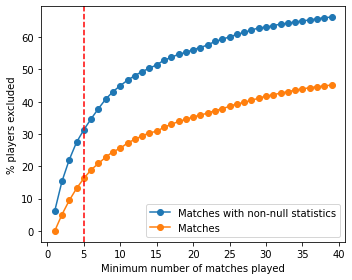

In [ ]:
# Consider the percentage of users removed depending on the min number of statistical matches played, and plot them.

x = range(1,40)
plt.plot(x,[100 * ( - (1 - players_df.shape[0] + players_df[players_df['n_stat_matches'] > i].shape[0])) / players_df.shape[0] for i in x], marker='o', label='Matches with non-null statistics')
plt.plot(x,[100 * ( - (1 - players_df.shape[0] + players_df[players_df['n_matches'] > i].shape[0])) / players_df.shape[0] for i in x], marker='o', label='Matches')

plt.gcf().set_size_inches(5, 4)
plt.xlabel('Minimum number of matches played')
plt.ylabel('% players excluded')
plt.legend()

# Highlight with a red dashed line the point where we actually cut the dataset.
plt.axvline(x=n_stat_matches_threshold, color="red", linestyle='--')
Library.save('players_removed_percentages.svg')
plt.show()

In [ ]:
# Execute the outlier removal process on the players_df.
# Note that in this case the only outlier removal is applied on the number of statistically relevant matches.

print('(players_df) Initial size =', players_df.shape[0])

def players_outliers_callback(df, a):
    if a == 'n_stat_matches':
        print(f"(players_df) Size after removing players with non-statistically relevant number of matches = {df.shape[0]}")
    else:
        print(f"(players_df) Size after removing players on {a} = {df.shape[0]}")

players_df = Library.drop_outliers(players_df, players_statistics, players_outliers_callback)

(players_df) Initial size = 2794
(players_df) Size after removing players with non-statistically relevant number of matches = 1918


## <hr><center>Final player's profiles  `players_df`.</center><hr>

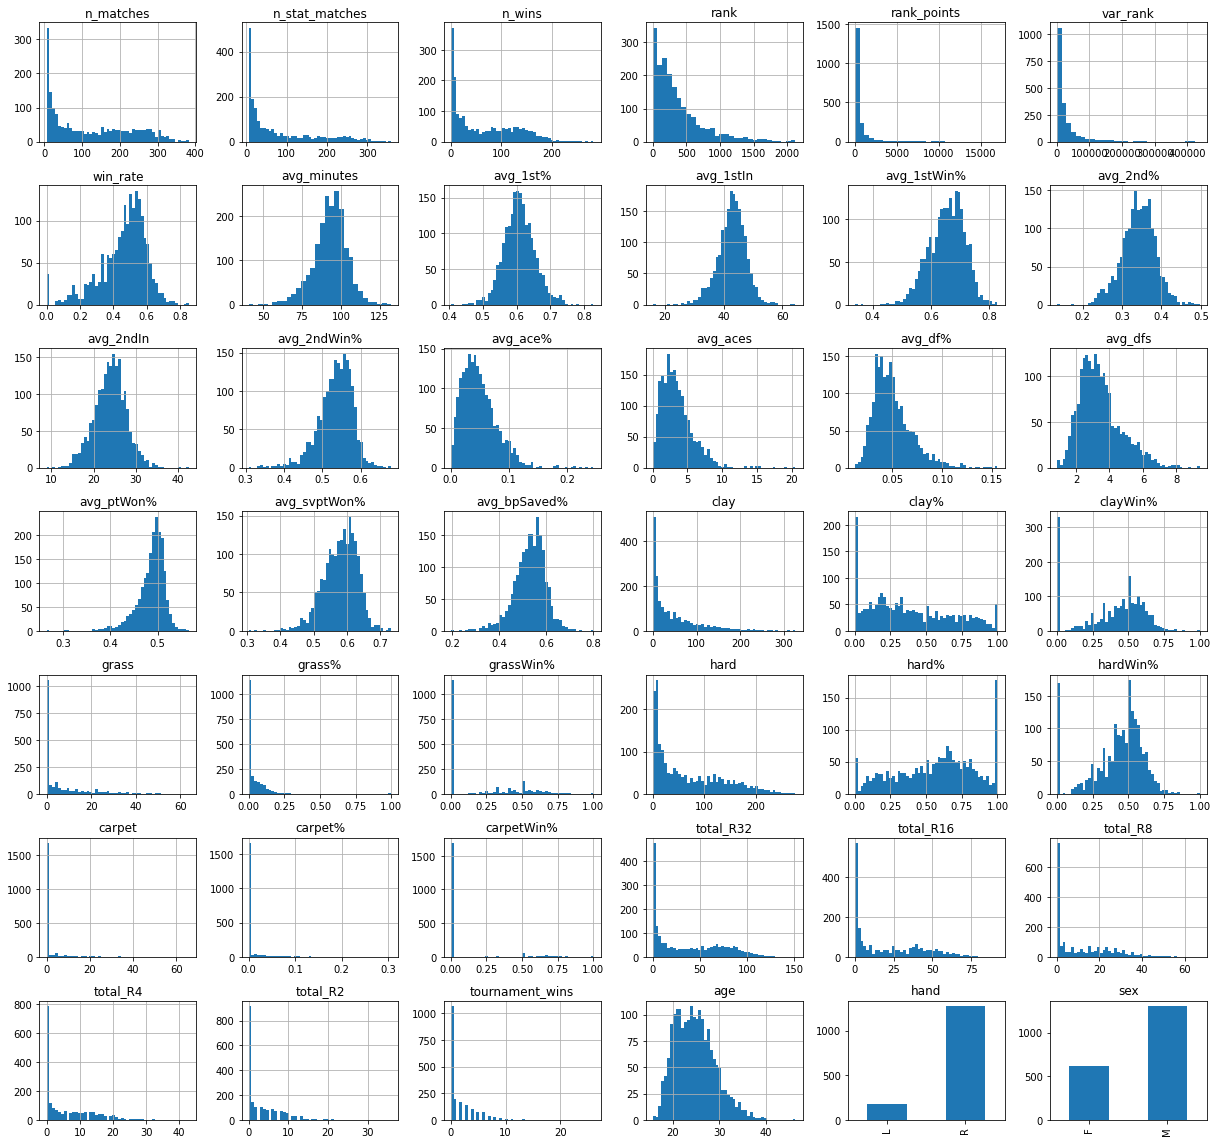

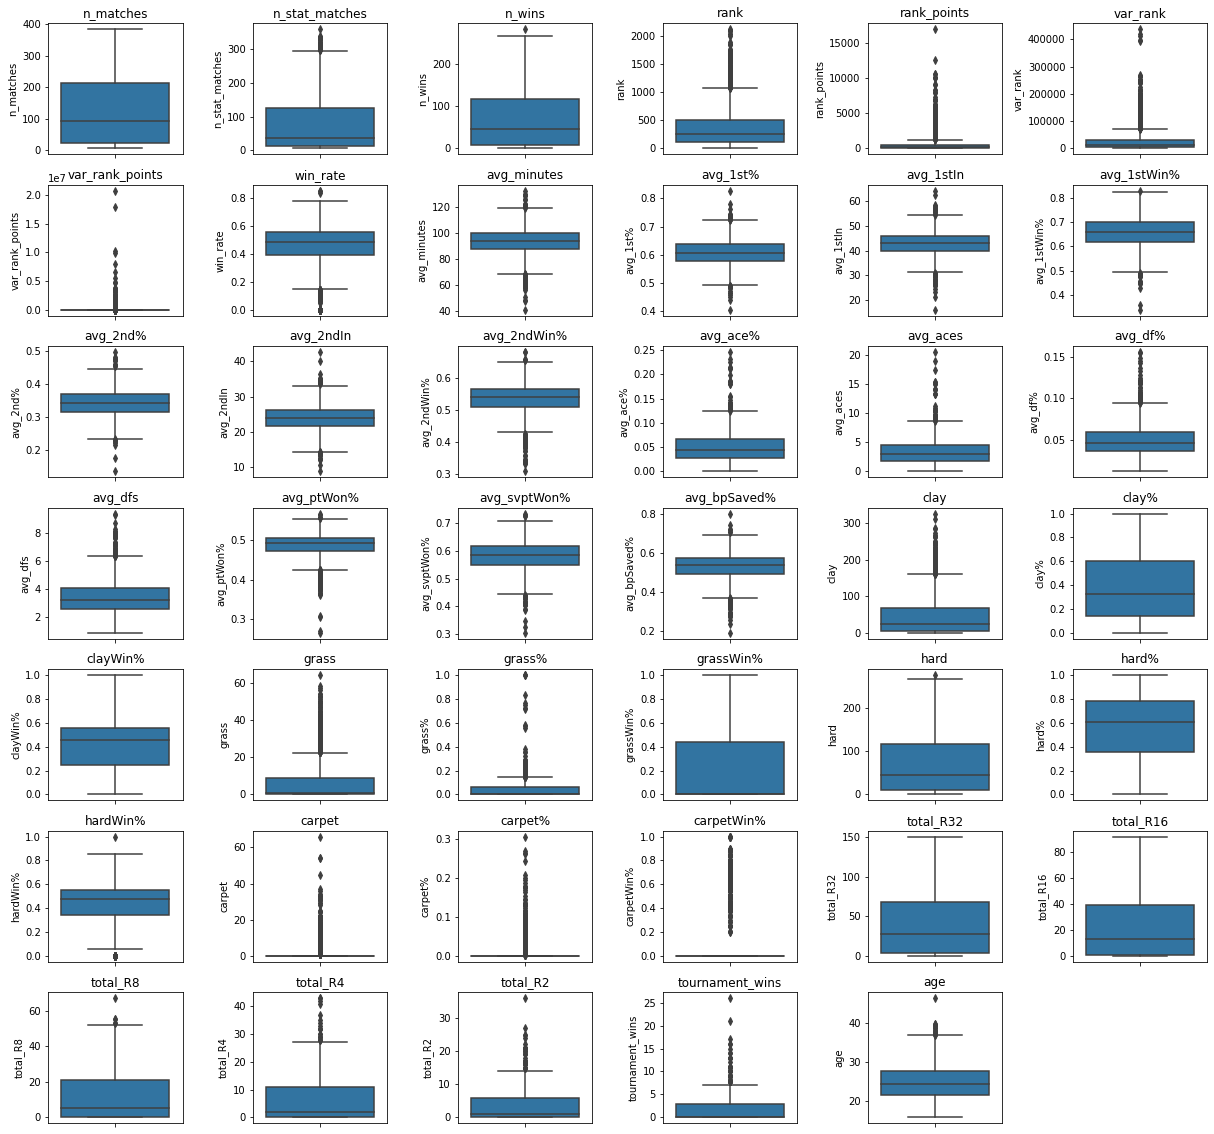

In [ ]:
# Plot again the main statistics on the final profiles with the filtering on the statistical matches applied.
 
players_df_histograms_and_boxplots('players_statistics_histograms_no_outliers.svg', 'players_statistics_boxplots_no_outliers.svg')

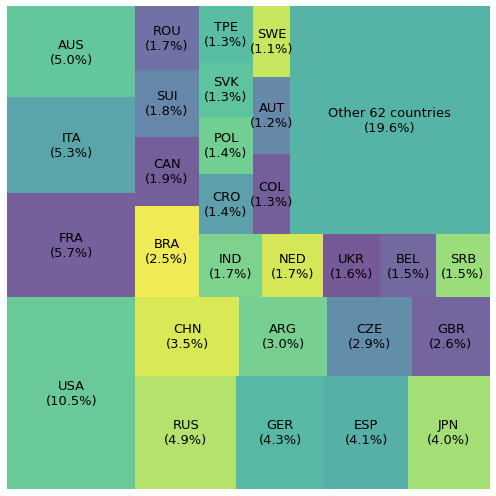

In [ ]:
# Display the countries of the players.

iocs = players_df['ioc'].copy()
k = iocs.value_counts()

# The countries with less than 20 players are collapsed into a single common square.
limit = 20

labels = list(k[k > limit].keys()) + [f'Other {k[k <= limit].shape[0]} countries']
sizes = list(k[k > limit].values) + [k[k <= limit].sum()]
perc_labels = [f'{l}\n({round(s/sum(sizes)*100,1)}%)' for s, l in zip(sizes, labels)]

plt.axis('off')
plt.gcf().set_size_inches(7, 7)
squarify.plot(sizes=sizes, label=perc_labels, text_kwargs={'fontsize':13}, alpha=0.75)
Library.save('players_countries.svg')

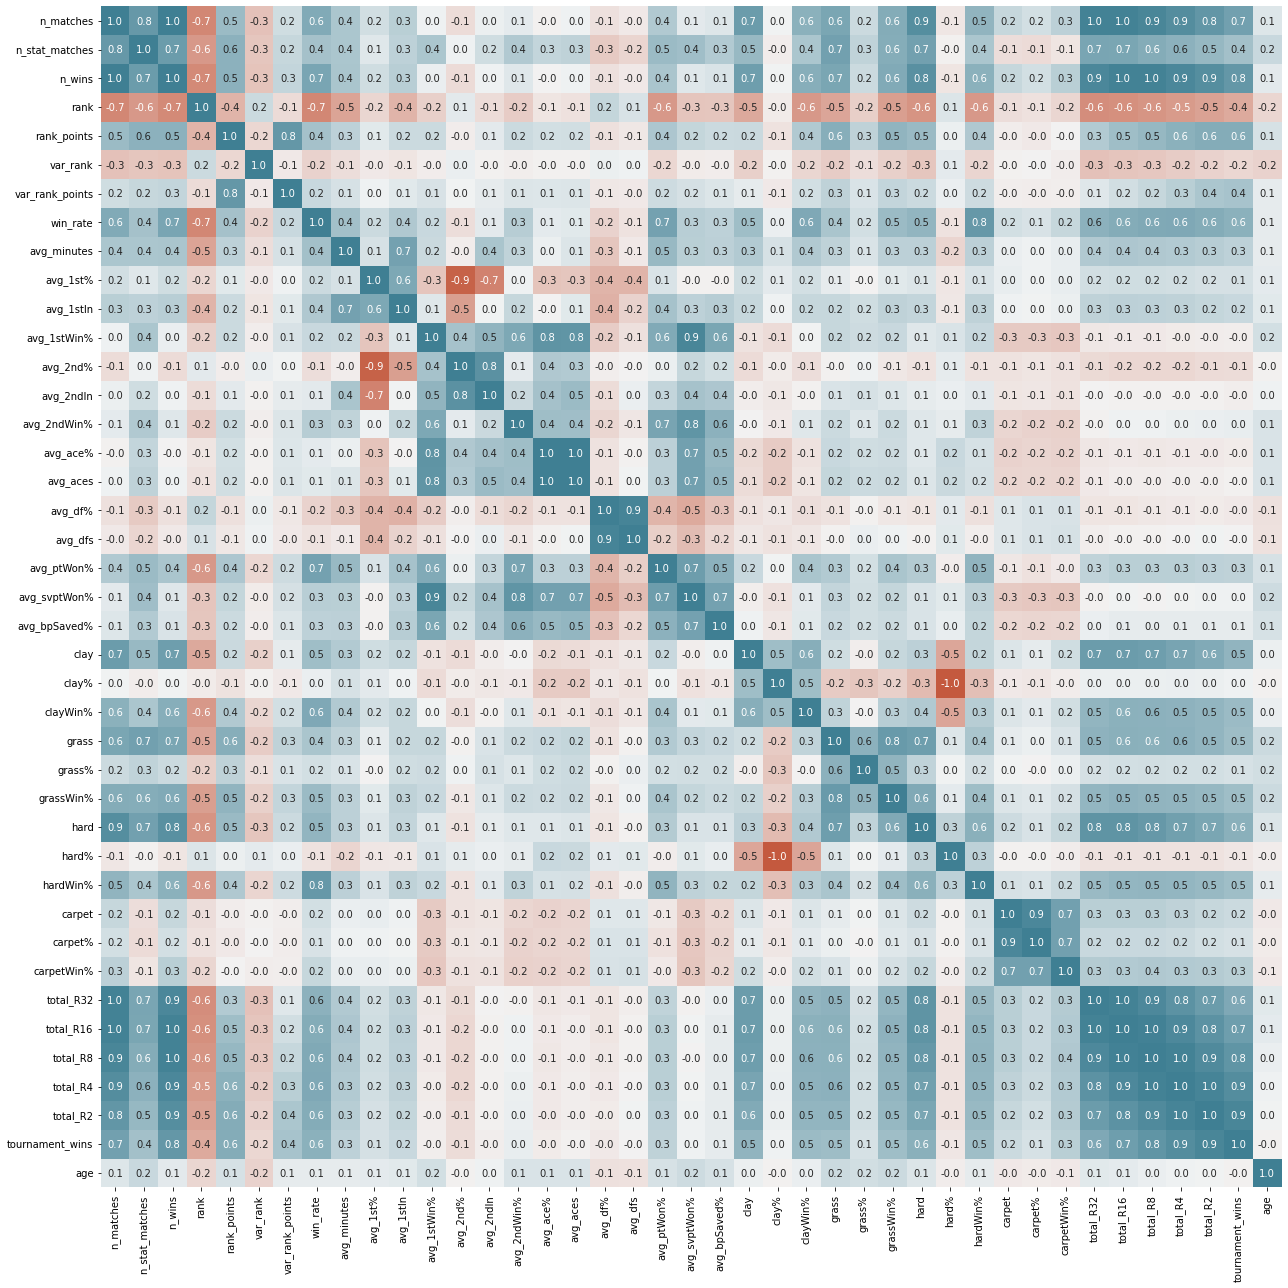

In [ ]:
# Show the main correlations on the cleaned dataset between all numerical attributes.

plt.gcf().set_size_inches(18, 18)
Library.correlation_matrix(players_df[Library.numerical_attributes(players_statistics)], annot=True, fmt='.1f', cbar=False)
Library.save("players_correlations.svg")

## <hr><center>Save the main datasets into the `data_cleaned` folder</center><hr>

In [ ]:
# Save the cleaned dataset in a shared but separate folder in order to split the concerns and make the notebooks modular.
# This also has the advantage of not having to re-run the cleaning process every time we want to use other notebooks.

Library.create_folder('../data_cleaned')

# Serialize both datasets to the shared folder.

print(f'(players_df) Saving {match_side_df.shape[0]} rows to "../data_cleaned/match_side_df.csv"')
match_side_df.to_csv('../data_cleaned/matches_side.csv')

print(f'(players_df) Saving {players_df.shape[0]} rows to "../data_cleaned/players_df.csv"')
players_df.to_csv('../data_cleaned/players.csv')

(players_df) Saving 370946 rows to "../data_cleaned/match_side_df.csv"
(players_df) Saving 1918 rows to "../data_cleaned/players_df.csv"


In [ ]:
# Serialize the dataset statistics dictionary for easy retrieval on other notebooks.

print(f'(match_side_df) Saving {len(match_side_statistics)} attributes to "../data_cleaned/match_side_df.stat"')
Library.serialize_statistics(match_side_statistics, '../data_cleaned/match_side_df.stat')

print(f'(players_df) Saving {len(players_statistics)} attributes to "../data_cleaned/players_df.stat"')
Library.serialize_statistics(players_statistics, '../data_cleaned/players_df.stat')

(match_side_df) Saving 60 attributes to "data/match_side_df.stat"
(players_df) Saving 48 attributes to "data/players_df.stat"


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52344550-8347-4668-936e-f505b5adca8e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>